# Investigating and predicting ASD diagnoses

In this exercise, we will work with a sample dataset (`autism_data.csv` in the same directory as this notebook) containing the results of a questionnaire for about 700 individuals, some of whom were positively diagnosed with autism spectrum disorder (ASD). This dataset is a trimmed version of a publicly available dataset [here](https://archive.ics.uci.edu/ml/datasets/Autism+Screening+Adult).

> **Some context:** ASD is a complex condition which manifests itself in many ways, so clinicians and behavioral analysts who diagnose and treat ASD need a variety of tools and assessments to help them identify ASD and its severity. Hence, multiple questionnaires and observational assessments are often conducted on patients, e.g., when a clinician or behavioral analyst engages in various activities with a child to understand their abilities on various tasks. 


The list below provides a brief description of each of the columns in the data:

|  Column(s)  |                                         Description                                                       |
|-------------|-----------------------------------------------------------------------------------------------------------|
| A1 - A2 | Some of the questions relating to the individual's behaviors |
| age | The individuals age at the time of taking taking the questionnaire |
| gender | The gender of the individual |
| ethnicity | The race/ethinicity of the individual - the original research was from New Zealand, but race/ethnic backgrounds were modified to match US Census categories |
| jaundice | Whether or not the invididual has jaundice |
| family_autism_hist | Whether or not there is a family history of autism for client |
| country_of_res | The country where the client resides |
| used_app_before | Has the individual completed the questionnaire before |
| ASD | Whether or not the individual is suspected of having ASD |


## Step 1: Libraries

Below we import some libraries which may be helpful during our analysis.

In [1]:
import numpy as np # version 1.23.1
import pandas as pd # version 1.4.3
import scipy as scp # version 1.8.1

## Step 2: Data Loading

In [2]:
# Load the dataset and perform any initial examination that's necessary
data = pd.read_csv("autism_data.csv")
data

,A1_Score,A2_Score,age,gender,ethnicity,jaundice,family_autism_hist,country_of_res,used_app_before,ASD
0,1.0,1.0,NaN,f,NaN,NaN,NaN,United States,0.0,0
1,1.0,1.0,NaN,m,NaN,0.0,1.0,Brazil,NaN,0
2,1.0,1.0,27.0,m,Hispanic,1.0,NaN,NaN,NaN,1
3,NaN,1.0,35.0,f,White,0.0,1.0,United States,NaN,0
4,1.0,0.0,40.0,f,NaN,0.0,0.0,Egypt,0.0,0
...,...,...,...,...,...,...,...,...,...,...
699,NaN,1.0,NaN,f,White,0.0,0.0,Russia,0.0,1
700,NaN,0.0,NaN,m,Hispanic,NaN,0.0,Mexico,NaN,0
701,NaN,0.0,24.0,f,Unknown,NaN,0.0,Russia,0.0,1
702,1.0,0.0,35.0,NaN,Asian,0.0,0.0,Pakistan,NaN,0


Seems like there're lots of `NaN`s in many of the feature columns $-$ not too surprising for a health survey, but might pose challenges to data analysis later on.

In [3]:
# Inspect summary statistics (of numerical columns)

data.describe()

,A1_Score,A2_Score,age,jaundice,family_autism_hist,used_app_before,ASD
count,524.000000,530.000000,511.000000,525.000000,528.000000,550.000000,704.000000
mean,0.719466,0.439623,29.845401,0.093333,0.136364,0.014545,0.268466
std,0.449690,0.496810,18.405497,0.291176,0.343500,0.119833,0.443476
min,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,35.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,383.000000,1.000000,1.000000,1.000000,1.000000


**Observations:**

- The maximum value in the **age** column, 383, seems unrealistic. Data entry error?

- The spread of values in the **age** column indicates that the survey respondents were predominantly adults, which is consistent with the information given to us about the data set.

- Rest of the numerical columns seem to contain boolean data $-$ their values all fall within [0, 1] $-$ which is consistent with what we know about them.

In [4]:
# Check for inappropriate data types and existence of nulls

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   A1_Score            524 non-null    float64
 1   A2_Score            530 non-null    float64
 2   age                 511 non-null    float64
 3   gender              519 non-null    object 
 4   ethnicity           528 non-null    object 
 5   jaundice            525 non-null    float64
 6   family_autism_hist  528 non-null    float64
 7   country_of_res      521 non-null    object 
 8   used_app_before     550 non-null    float64
 9   ASD                 704 non-null    int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 55.1+ KB


## Step 3: Data Exploration

In this section we'll examine some of the features in the dataset and attempt to understand why certain variables exhibit certain values and distributions.

#### 3a. To get started, let's determine the ratio of males to females in the dataset. We also provide a visualization showcasing the ratio.

<div class="alert alert-block alert-warning"> 
    <span style="color:black">
        One important qualifier to keep in mind when interpreting the visualization is that, about 1/4 of the records in the data set do not have clearly identified genders (the NaNs).
    </span>
</div>

In [5]:
# Import matplotlib and relevant sub-modules for visualization purposes.

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as patches

%matplotlib inline

%config InlineBackend.figure_format = 'retina' 

In [6]:
# Preview gender counts.

data["gender"].value_counts()

m    267
f    252
Name: gender, dtype: int64

Text(0.95, 260, '252')

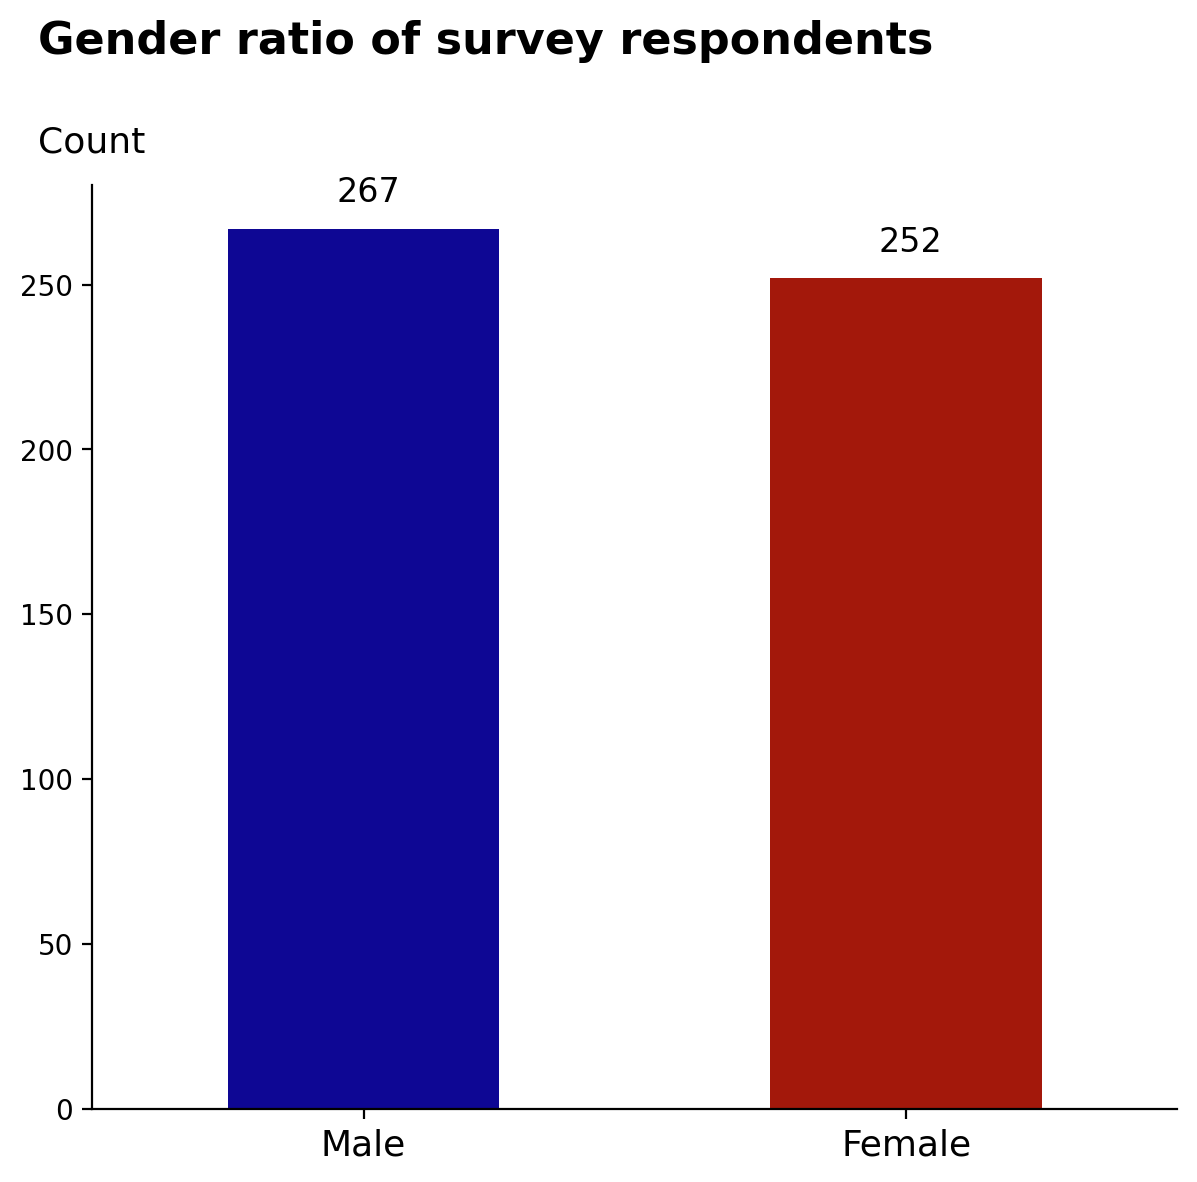

In [7]:
# Code for gender ratio and visualization

ax = data["gender"].value_counts()\
                   .plot(kind='bar', 
                         figsize=(7, 6), 
                         rot=0, 
                         color=['#0e0794','#a3180b']
                        )

# Modify bar labels on the x-axis for better readability.
ax.set_xticklabels(['Male', 'Female'], size=13)

# Add customized y-axis label (horizontal for better readability).
ax.annotate('Count', (-0.6, 290), size=13, annotation_clip=False)

# Add customized title.
ax.annotate('Gender ratio of survey respondents', (-0.6, 320), size=16, annotation_clip=False, weight='bold')

# Only show the x and y axes. Hide top and right bounding lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Indicate exact counts.
male_count = data["gender"].value_counts()['m']
female_count = data["gender"].value_counts()['f']
ax.annotate(f'{male_count}', (-0.05, 275), size=12, annotation_clip=False)
ax.annotate(f'{female_count}', (0.95, 260), size=12, annotation_clip=False)

#### 3b. To really understand if the ratio of gender seems appropriate, the next task to is look at whether or not the presence of ASD varies significantly between males and females. Let's take a look at the ratio of males to females when accounting for a diagnosis of ASD.

In [8]:
# Generate a copy of the desired data subset to prevent modifications to original data.
df_3b = data[['gender', 'ASD']].copy()

# Drop all rows with NaN.
df_3b = df_3b.dropna().reset_index(drop=True)

# Get data subset of patients with positive ASD diagnosis.
df_3b_ASD = df_3b.loc[df_3b['ASD']==1]

# Get data subset of patients with negative ASD diagnosis.
df_3b_noASD = df_3b.loc[df_3b['ASD']==0]

# Get male data.
male_count_ASD = df_3b_ASD['gender'].value_counts()['m']
male_count_noASD = df_3b_noASD['gender'].value_counts()['m']
male_counts = [male_count_ASD, male_count_noASD] # concatenating counts for plotting (see next cell)

# Get female data.
female_count_ASD = df_3b_ASD['gender'].value_counts()['f']
female_count_noASD = df_3b_noASD['gender'].value_counts()['f']
female_counts = [female_count_ASD, female_count_noASD] # concatenating counts for plotting (see next cell)

Text(0.96, 181, '174')

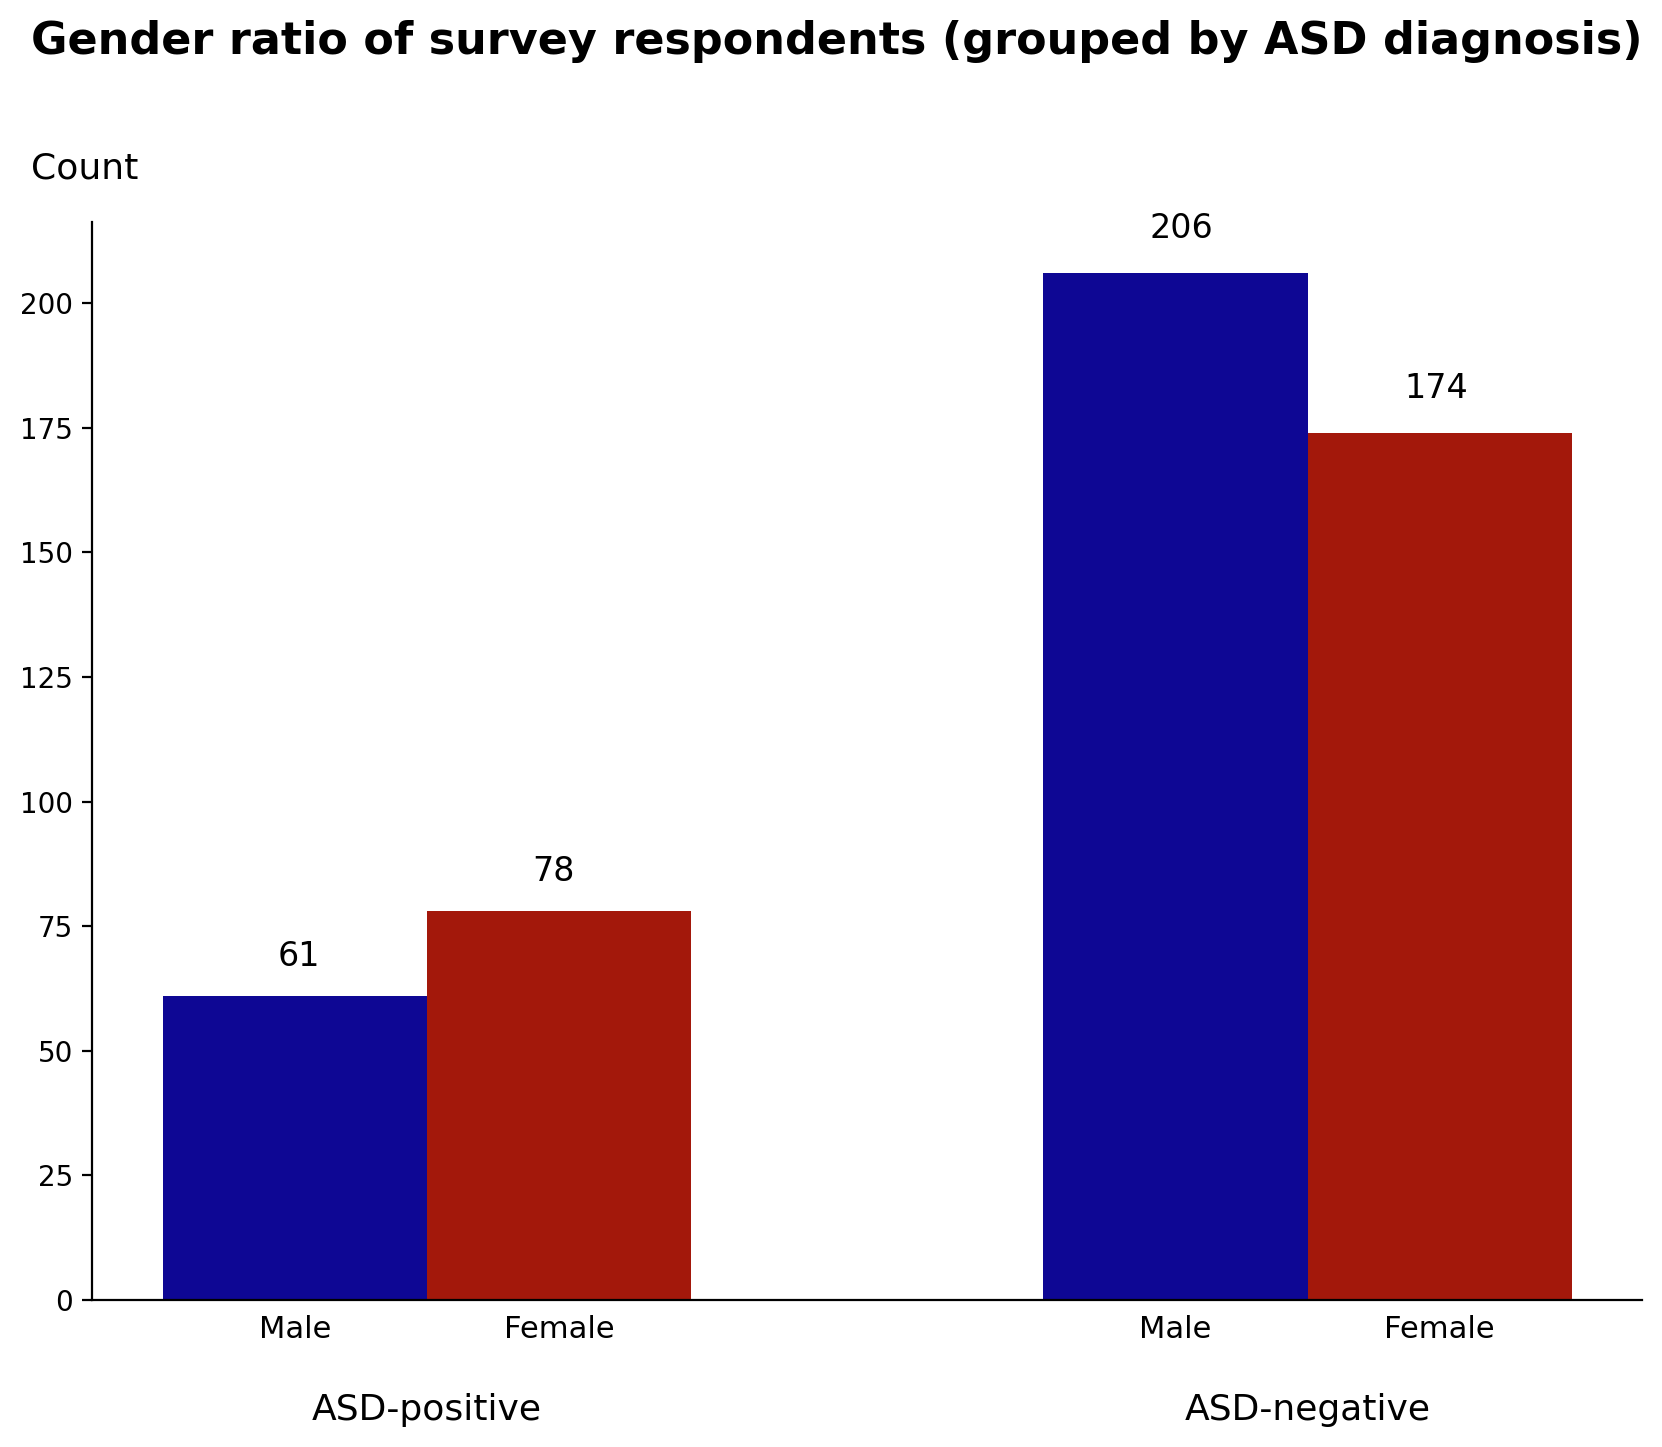

In [9]:
# Visualize gender ratios for both positive and negative diagnoses of ASD (side-by-side)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# Plot the bars.
w = .3
ax.bar(np.arange(2)-w, male_counts, width=w, color='#0e0794', label="Male")
ax.bar(np.arange(2), female_counts, width=w, color='#a3180b', label="Female")

# Only show the x and y axes. Hide top and right bounding lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Configure x-axes.
ax.set_xticks([-0.3, 0, 0.7, 1], minor=True)
ax.set_xticklabels(['Male','Female','Male','Female'], minor=True)
ax.set_xticks([-0.15, 0.85])
ax.set_xticklabels(['ASD-positive','ASD-negative'])
ax.tick_params(axis='x', which='major', bottom=False, pad=30, labelsize=13)
ax.tick_params(which='minor', bottom=False, labelsize=11)

# Add customized y-axis label (horizontal for better readability).
ax.annotate('Count', 
            (-0.6, 225), 
            size=13, 
            annotation_clip=False
           )

# Add customized title.
ax.annotate('Gender ratio of survey respondents (grouped by ASD diagnosis)', 
            (-0.6, 250), 
            size=16, 
            annotation_clip=False, 
            weight='bold'
           )

# Indicate exact counts.
ax.annotate(f'{male_count_ASD}', (-0.32, 67), size=12, annotation_clip=False)
ax.annotate(f'{female_count_ASD}', (-0.03, 84), size=12, annotation_clip=False)
ax.annotate(f'{male_count_noASD}', (0.67, 213), size=12, annotation_clip=False)
ax.annotate(f'{female_count_noASD}', (0.96, 181), size=12, annotation_clip=False)

#### 3c. Now that we've examined the level of ASD with respect to gender, let's see if this matches up with the trends commonly seen in the ASD population as a whole. Does the dataset align with what is seen in the ASD population?

The data concerning the gender ratio for the ASD-positive group does not *seem* consistent with common trends in the ASD population as a whole.

> Suggesting (?) that this data might not be the best sample on which to perform gender/sex-specific analyses. 

> But, then again, this could simply have been due to the significant (~1/4) number of records where the respondent's gender was not specified. (Difficult to tell, without additional information about the data collection process.)

**Some facts we know:**

- "Autism spectrum disorder (ASD) is a developmental condition that affects approximately four times as many males as females, a strong *sex* bias that has not yet been fully explained." ([Source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5112643/)) 


- Further, there is genetic evidence that supports this so-called 'female protective effect'. ([Source](https://www.nature.com/articles/s41398-020-0699-8)) However, *sex* and *gender* are not identical concepts (though they may be strongly correlated). The same paper acknowledges that "further study is needed to integrate neuronal and hormonal data to elucidate the underlying *gender* difference in ASD."


- In fact, another paper suggests that "this sex/gender difference might be partially explained by biological risk factors, but it is probably also bound to methodological issues". ([Source](https://www.frontiersin.org/articles/10.3389/fpsyt.2021.539835/full)) It also claims that "there are subtle, yet potentially meaningful, quantitative, and qualitative phenotypic differences between females and males that common screening tests are not always sensitive enough to recognize."

> An objection against taking this study seriously for our purposes could be that its experimental subjects were children and adolescents (3-18 years), while most of the respondents in our data set were adults.

#### 3d. In addition to age, one of the key variables present in the data is whether or not the individual had jaundice. To visualize the co-occurrence of jaundice and ASD, let's plot the relationship between the presence of jaundice and ASD with a similar plot.

In [10]:
# Code for examining jaundice and ASD

# Generate a copy of the desired data subset to prevent modifications to original data.
df_3d = data[['jaundice', 'ASD']].copy()

# Drop all rows with NaN.
df_3d = df_3d.dropna().reset_index(drop=True)

# Convert floats in jaundice column to integers.
df_3d = df_3d.astype(int)

# Check.
df_3d

,jaundice,ASD
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0
...,...,...
520,0,0
521,0,1
522,0,1
523,0,0


In [11]:
# Make sense of the numbers before plotting.

pd.crosstab(df_3d['jaundice'], df_3d['ASD'])

ASD,0,1
jaundice,,
0,351,125
1,31,18


By performing some simple probability-related calculations on these numbers, we can guess that the presence of jaundice *might* have a significant effect on testing positive for ASD. The probability of someone testing positive for ASD, *given that he/she does not have jaundice*, is:

$$\mathrm{Pr}\hspace{0.7mm}[\text{ASD=1| jaundice=0}] = \frac{125}{125 + 351} = 0.26$$

However, the probability of someone testing positive for ASD, *given that he/she has jaundice*, is:

$$\mathrm{Pr}\hspace{0.7mm}[\text{ASD=1| jaundice=1}] = \frac{18}{31 + 18} = 0.37$$

Thus, having jaundice actually increases the chance of a positive ASD diagnosis by $(0.37 - 0.26)\times 100\% = 11\%$ . This is a *significant* difference!

> **Note:** This does not imply that the reverse statement (i.e., having a positive ASD diagnosis *significantly* increases the chance of having jaundice) is true. The probability of someone having jaundice, given that he/she tested negative for ASD, is:
> 
> $$\mathrm{Pr}\hspace{0.7mm}[\text{jaundice=1| ASD=0}] = \frac{31}{31 + 351} = 0.08$$
>
> However, the probability of someone having jaundice, given that he/she tested positive for ASD, is:
>
> $$\mathrm{Pr}\hspace{0.7mm}[\text{jaundice=1| ASD=1}] = \frac{18}{18 + 125} = 0.13$$
>
> In this way, having a positive ASD diagnosis *does* increase the chance of someone having jaundice, albeit by a much smaller chance of $(0.13 - 0.08)\times 100\% = 5\%$.

In any case, these results suggest that there is some relationship (of positive correlation) between having jaundice and testing positive for ASD\*.

> \* A point of subtlety that may be important on another occasion: Having a positive ASD diagnosis =/= having ASD.

Indeed, studies like [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4285414/) have shown that "overall, jaundice ... (is) associated with ASD".  

> Nonetheless, it might be worthwhile to note that almost all of such studies (including the one cited above) have *neonatal experimental subjects* while the respondents in our data set are adults. Direct evidence of an association between jaundice and ASD *in adults* seems scarce, as per the author's attempt [here](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&as_vis=1&q=autism+spectrum+disorder+and+adult+jaundice&btnG=).

In [12]:
# Get data subset of patients with jaundice.
df_3d_Jaundice = df_3d.loc[df_3d['jaundice']==1]

# Get data subset of patients without jaundice.
df_3d_noJaundice = df_3d.loc[df_3d['jaundice']==0]

# Get ASD-positive data.
asdPositive_count_Jaundice = df_3d_Jaundice['ASD'].value_counts(normalize=True)[1] # normalized to get relative frequency
asdPositive_count_Jaundice = round(asdPositive_count_Jaundice*100, 2) # Convert to percentage and round to 2 decimal places
asdPositive_count_noJaundice = df_3d_noJaundice['ASD'].value_counts(normalize=True)[1] # normalized to get relative frequency
asdPositive_count_noJaundice = round(asdPositive_count_noJaundice*100, 2) # Convert to percentage and round to 2 decimal places
asdPositive_counts = [asdPositive_count_Jaundice, asdPositive_count_noJaundice] # concatenating counts for plotting (see next cell)

# Get ASD-negative data.
asdNegative_count_Jaundice = df_3d_Jaundice['ASD'].value_counts(normalize=True)[0] # normalized to get relative frequency
asdNegative_count_Jaundice = round(asdNegative_count_Jaundice*100, 2) # Convert to percentage and round to 2 decimal places
asdNegative_count_noJaundice = df_3d_noJaundice['ASD'].value_counts(normalize=True)[0] # normalized to get relative frequency
asdNegative_count_noJaundice = round(asdNegative_count_noJaundice*100, 2) # Convert to percentage and round to 2 decimal places
asdNegative_counts = [asdNegative_count_Jaundice, asdNegative_count_noJaundice] # concatenating counts for plotting (see next cell)

Text(0.94, 36.87, '73.74')

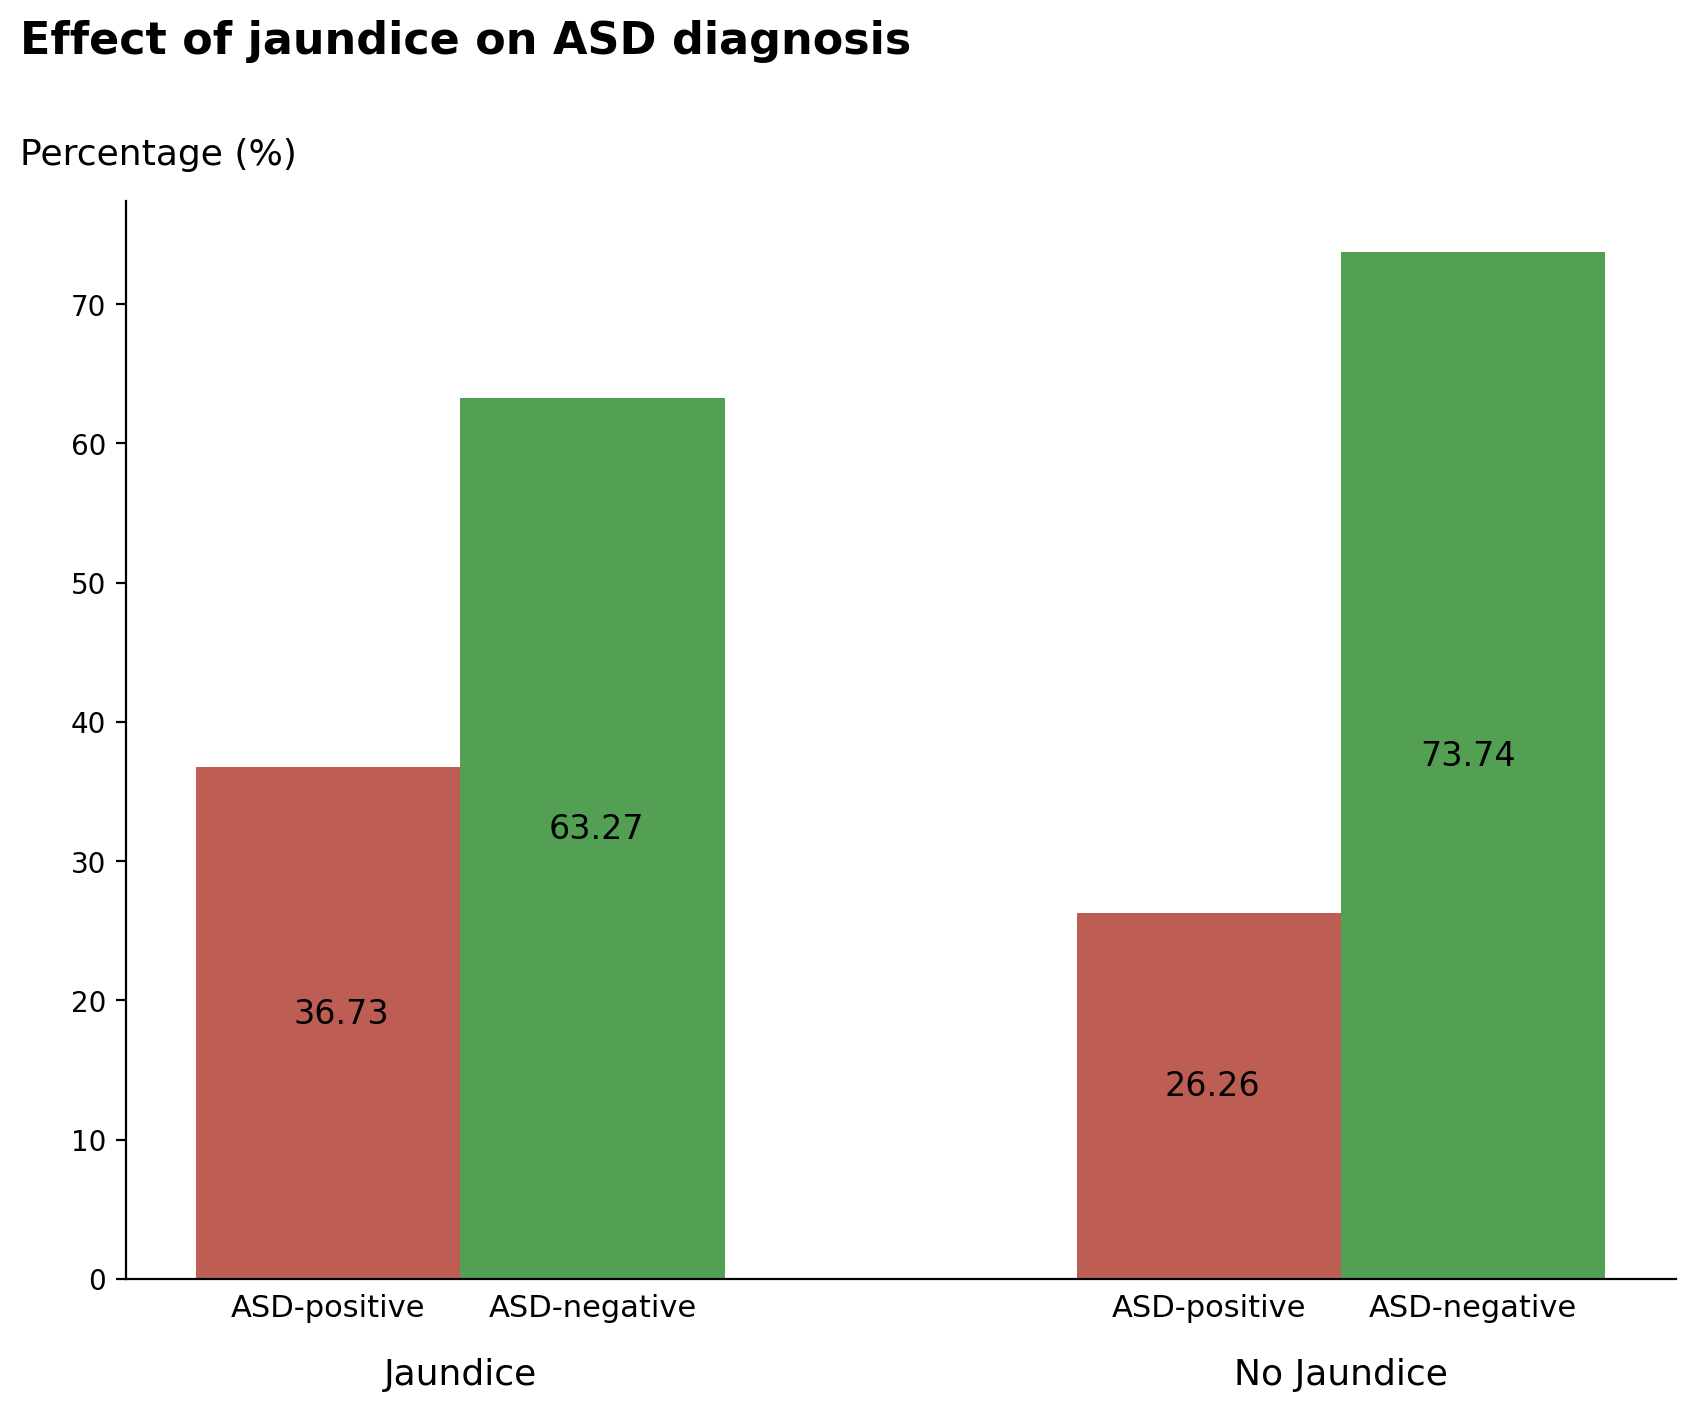

In [13]:
# Visualize positive/negative diagnoses of ASD with presence/lack thereof of jaundice (side-by-side)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# Plot the bars.
w = .3
ax.bar(np.arange(2)-w, asdPositive_counts, width=w, color='#a3180b', label="ASD-positive", alpha=0.7)
ax.bar(np.arange(2), asdNegative_counts, width=w, color='#0a780d', label="ASD-negative", alpha=0.7)

# Only show the x and y axes. Hide top and right bounding lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Configure x-axes.
ax.set_xticks([-0.3, 0, 0.7, 1], minor=True)
ax.set_xticklabels(['ASD-positive','ASD-negative','ASD-positive','ASD-negative'], minor=True)
ax.set_xticks([-0.15, 0.85])
ax.set_xticklabels(['Jaundice','No Jaundice'])
ax.tick_params(axis='x', which='major', bottom=False, pad=25, labelsize=13)
ax.tick_params(which='minor', bottom=False, labelsize=11)

# Add customized y-axis label (horizontal for better readability).
ax.annotate('Percentage (%)', 
            (-0.65, 80), 
            size=13, 
            annotation_clip=False
           )

# Add customized title.
ax.annotate('Effect of jaundice on ASD diagnosis', 
            (-0.65, 88), 
            size=16, 
            annotation_clip=False, 
            weight='bold'
           )

# Indicate exact counts.
ax.annotate(f'{asdPositive_count_Jaundice}', (-0.34, 18.36), size=12, annotation_clip=False)
ax.annotate(f'{asdNegative_count_Jaundice}', (-0.05, 31.63), size=12, annotation_clip=False)
ax.annotate(f'{asdPositive_count_noJaundice}', (0.65, 13.13), size=12, annotation_clip=False)
ax.annotate(f'{asdNegative_count_noJaundice}', (0.94, 36.87), size=12, annotation_clip=False)

The graph suggests the same conclusion:

> While having jaundice does not make someone likely (in *absolute* terms, i.e., < 50% chance) to have a positive ASD diagnosis, it does make someone *likelier* $-$ by a *nontrivial* amount of about 11% $-$ to be diagnosed with ASD!

## Step 4: Feature Processing and Data Preparation

Now that we've completed some feature processing, we can go ahead and begin some machine learning modeling tasks. The goal of the machine learning model is to predict whether or not an individual has ASD (that is the ASD column in the dataset).

### Deal with outliers in the data

In [70]:
# Generate a copy of the data set to prevent modifications to original data.
df = data.copy()

Earlier, we noticed that there was a record wherein the person's age was 383 years. Let's broaden our search to check if there are other records with unrealistic values for **age**:

In [74]:
df.loc[df["age"] > 70]

,A1_Score,A2_Score,age,gender,ethnicity,jaundice,family_autism_hist,country_of_res,used_app_before,ASD
52,1.0,0.0,383.0,f,NHOPI,NaN,NaN,NaN,0.0,0


Seems like said record is the only anomalous record. For convenience, let's just assume '383.0' was a typo and replace it with '38' (which would be likelier than '83', since it lies just within one standard deviation of the mean age $-$ with this anomalous age value itself excluded).

In [78]:
df.loc[df["age"]!=383.0]['age'].describe()

count    510.000000
mean      29.152941
std        9.691313
min       17.000000
25%       21.000000
50%       26.500000
75%       35.000000
max       61.000000
Name: age, dtype: float64

In [79]:
# Replace anomaly.

df.loc[52, 'age'] = 38

In [80]:
# Check that replacement was successful.

df['age'].describe()

count    511.000000
mean      29.170254
std        9.689714
min       17.000000
25%       21.000000
50%       27.000000
75%       35.000000
max       61.000000
Name: age, dtype: float64

### Deal with missing values in the data

In [81]:
# Try dropping all rows with NaN.
df.dropna().reset_index(drop=True)

,A1_Score,A2_Score,age,gender,ethnicity,jaundice,family_autism_hist,country_of_res,used_app_before,ASD
0,1.0,1.0,29.0,m,White,0.0,0.0,United States,0.0,0
1,0.0,1.0,38.0,m,Unknown,0.0,0.0,United Arab Emirates,0.0,0
2,0.0,0.0,40.0,m,NHOPI,1.0,1.0,United Arab Emirates,0.0,0
3,0.0,0.0,48.0,m,Black,0.0,0.0,New Zealand,0.0,0
4,0.0,0.0,55.0,m,White,0.0,0.0,New Zealand,0.0,0
5,1.0,1.0,43.0,f,White,0.0,0.0,Australia,0.0,1
6,1.0,0.0,35.0,m,White,0.0,0.0,Saudi Arabia,0.0,0
7,1.0,0.0,20.0,m,White,0.0,0.0,United States,0.0,0
8,1.0,1.0,45.0,f,Unknown,1.0,0.0,Jordan,0.0,0
9,0.0,0.0,21.0,m,NHOPI,0.0,0.0,Oman,0.0,0


Clearly not feasible, since we would only have 58 records left, which is < 10% of the original number of records. So we have to *impute* the data.

---

### Imputing missing data

There are many ways to impute data. But given the sensitive nature of the information contained in our data set and the ethical consequences of deploying an ML model on "garbage" data, it might make sense to impute `NaN` fields with an `unknown` class wherever possible. Moreover, the missing-ness of data can sometimes be valuable information in itself.

> Another approach (that is probably more faithful to the spirit of the scientific method) is to try a range of imputation methods and compare the outcomes after running an ML model (of the same *initial* parameters, and with the same *hyperparameters*). But this is too laborious for the purpose of this exercise.

---

Anyhow, it is good practice to first split our data into train, validation, and test sets before performing imputation (to prevent the test set from influencing the imputation process):

In [82]:
from sklearn.model_selection import train_test_split

In [142]:
# Separate target variable column from the data.

X, y = df.loc[:, df.columns!='ASD'], df.loc[:, df.columns=='ASD']

In [143]:
# Set aside 20% of the data for evaluation/testing.
X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=8)

# Further split the non-test data into train and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X_remain, y_remain, test_size=0.25, random_state=8)

# Reset indices now to prevent future troubles.
for d in [X_train, X_val, X_test, y_train, y_val, y_test]:
    d.reset_index(inplace=True, drop=True)

# Verify that splitting worked by checking dimensions.
print("TRAIN SET")
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("\nVALIDATION SET")
print("X_val shape: {}".format(X_val.shape))
print("y val shape: {}".format(y_val.shape))
print("\nTEST SET")
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

TRAIN SET
X_train shape: (422, 9)
y_train shape: (422, 1)

VALIDATION SET
X_val shape: (141, 9)
y val shape: (141, 1)

TEST SET
X_test shape: (141, 9)
y_test shape: (141, 1)


Back to imputation.


We know that **age** is the only *quantitative* (i.e., non-categorical) variable in the data, and we have *a priori* information that the survey respondents are predominantly adults. It should therefore be reasonable to do a *mean imputation* for the **age** column, *within each* of the train, validation, and test sets:

In [148]:
# Replace missing values in AGE column with the column mean.

X_train['age'] = X_train['age'].fillna(X_train['age'].mean())
X_val['age'] = X_val['age'].fillna(X_val['age'].mean())
X_test['age'] = X_test['age'].fillna(X_test['age'].mean())

In [149]:
# To make the 'age' values more sensible, we can also round them to their nearest integers.

for x in [X_train, X_val, X_test]:
    x['age'] = round(x["age"]).astype(int)

Now, let's impute the rest of the feature columns with `unknown`:

In [150]:
# Replace missing values in other (categorical) columns with 'Unknown'.

X_train = X_train.fillna("Unknown")
X_val = X_val.fillna("Unknown")
X_test = X_test.fillna("Unknown")

### Encoding categorical variables

- For variables with low cardinality (i.e., binary features like **A1_Score**, **A2_Score**, **gender**, **jaundice**, **family_autism_hist**, and **used_app_ before**), we may use *one-hot encoding*. 


- For variables with high cardinality (i.e., **ethnicity** and **country_of_res**), we may use *feature hashing*. (It wouldn't make sense to use one-hot encoding, since neither of these variables is ordinal. Target encoding might work, though.)

In [151]:
# One-hot encode low-cardinality variables.

X_train = pd.get_dummies(X_train, columns=["A1_Score", "A2_Score", "gender", "jaundice", "family_autism_hist", "used_app_before"])
X_val = pd.get_dummies(X_val, columns=["A1_Score", "A2_Score", "gender", "jaundice", "family_autism_hist", "used_app_before"])
X_test = pd.get_dummies(X_test, columns=["A1_Score", "A2_Score", "gender", "jaundice", "family_autism_hist", "used_app_before"])

In [152]:
from sklearn.feature_extraction import FeatureHasher

In [153]:
def hashing_trick(col, n_features=4):
    '''
    Function for hash-encoding high-cardinality variables. Value of n_features (4) was chosen with reference to:
    https://booking.ai/dont-be-tricked-by-the-hashing-trick-192a6aae3087
    '''
    name = col.name
    col = col.astype('str')
    col_names = [name + "_" + str(i+1) for i in range(n_features)]
    h = FeatureHasher(input_type='string', n_features=n_features)
    out = h.transform(col).toarray()
    return pd.DataFrame(out, columns=col_names)

In [154]:
# Hash-encode high-cardinality variables.

# Get columns to be hashed.
hash_columns = ['ethnicity', 'country_of_res']

# Get hash-encoded columns from training set.
train_hashed_dfs = [hashing_trick(X_train[c]) for c in hash_columns]
X_train_hashed = pd.concat(train_hashed_dfs, axis=1)

# Get hash-encoded columns from validation set.
val_hashed_dfs = [hashing_trick(X_val[c]) for c in hash_columns]
X_val_hashed = pd.concat(val_hashed_dfs, axis=1)

# Get hash-encoded columns from test set.
test_hashed_dfs = [hashing_trick(X_test[c]) for c in hash_columns]
X_test_hashed = pd.concat(test_hashed_dfs, axis=1)

In [155]:
# Get the other feature columns that were not hash-encoded.

# ... from training set.
X_train_others = X_train.loc[:, ~X_train.columns.isin(hash_columns)].copy()

# ... from validation set.
X_val_others = X_val.loc[:, ~X_val.columns.isin(hash_columns)].copy()

# ... from test set.
X_test_others = X_test.loc[:, ~X_test.columns.isin(hash_columns)].copy()

In [156]:
# Merge all encoded feature columns into one dataframe.

X_train_encoded = pd.concat([X_train_others, X_train_hashed], axis=1)
X_val_encoded = pd.concat([X_val_others, X_val_hashed], axis=1)
X_test_encoded = pd.concat([X_test_others, X_test_hashed],  axis=1)

### Standardizing the encoded feature variables

We need to ensure that the data are *scale-free* by transforming *each* feature column such that it becomes distributed with zero mean and unit variance. This will help prevent any machine learning model we apply subsequently from becoming biased in any direction in feature space.

In [157]:
from sklearn.preprocessing import StandardScaler

In [158]:
# Perform standard scaling. Fit scaler to encoded train data.

scaler = StandardScaler() 
scaler.fit(X_train_encoded)

StandardScaler()

In [159]:
# Use fitted scaler to transform training, validation and test sets.

X_train_scaled = scaler.transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

## Step 5: Modeling

---
I have opted to use a **logistic regression model** \*, for the following reasons:

>\* A logistic regression model is basically a linear regression model but with its real-valued outputs transformed (via the sigmoid function) into probabilities (falling between 0 and 1) that can then be compared with one or more categorical target variable(s). 

- It is more interpretable compared to other appropriate models like Random Forest and XGBoost (which, to their credit, would probably offer better performance on this data set). 


- Faster and easier to train.


- According to a [study](https://reader.elsevier.com/reader/sd/pii/S1877050920308656?token=CD3D681A395969B717AC3F57F6C9E51BEE4B3E362868F4C7C45F704356EBA8C53066718E69702255A44476A930867DDF&originRegion=us-east-1&originCreation=20230120203527) that attempted six different models on the same(?) data set, their logistic regression model achieved > 95% on specificity, sensitivity, and accuracy, and was inferior only to their neural network models. 

### Hyperparameter tuning

In [182]:
def custom_grid_search_alpha(i):
    '''
    Helper function to choose a particular value for the regularization term's coefficient.
    
    :i: An integer in [0, 10).
    
    '''
    penalties = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    penalty_alpha = penalties[i]
    return penalty_alpha

In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, classification_report, confusion_matrix

In [ ]:
# Perform hyper-parameter tuning.

penalty_list = []
trainLoss_list, valLoss_list = [], []
trainAUC_list, valAUC_list = [], []

for i in range(10):
    h = custom_grid_search_alpha(i)
    model = LogisticRegression(C=1/h, penalty='l2')
    model.fit(X_train_scaled, y_train)
    y_hat_train = model.predict_proba(X_train_scaled)[:,1]
    y_hat_val = model.predict_proba(X_val_scaled)[:,1]
    penalty_list.append(h)
    trainLoss_list.append(log_loss(y_train, y_hat_train))
    valLoss_list.append(log_loss(y_val, y_hat_val))
    trainAUC_list.append(roc_auc_score(y_train, y_hat_train))
    valAUC_list.append(roc_auc_score(y_val, y_hat_val))

In [186]:
# Show results of hyper-parameter tuning.

d = {'Regularization Term Coefficient': penalty_list, 
     'Log Loss (Train)': trainLoss_list, 'AUROC (Train)': trainAUC_list,
     'Log Loss (Validation)': valLoss_list, 'AUROC (Validation)': valAUC_list
    }
result = pd.DataFrame(data=d)
result

,Regularization Term Coefficient,Log Loss (Train),AUROC (Train),Log Loss (Validation),AUROC (Validation)
0,0.00001,0.463249,0.807421,0.542996,0.712418
1,0.00010,0.463249,0.807421,0.542996,0.712418
2,0.00100,0.463249,0.807421,0.542995,0.712418
3,0.01000,0.463249,0.807421,0.542987,0.712418
4,0.10000,0.463249,0.807506,0.542904,0.711916
5,1.00000,0.463294,0.807648,0.542150,0.710910
6,10.00000,0.465498,0.807251,0.538574,0.709904
7,100.00000,0.491770,0.802153,0.542785,0.692810
8,1000.00000,0.556549,0.792862,0.573018,0.679739
9,10000.00000,0.582075,0.790285,0.587574,0.674711


It seems that $0.01$ is the sweet-spot value for the L2 regularization term's coefficient.

## Step 6: Performance Analysis and Model Interpretation

In [187]:
# Fit final logistic regression model on training data.

a = 0.01
model = LogisticRegression(C=1/a, penalty='l2')
model.fit(X_train_scaled, y_train)

/opt/anaconda3/envs/FortaTHC/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=100.0)

In [197]:
# Get predicted labels.
y_proba = model.predict_proba(X_test_scaled)[:,1]

# Fitted model's log-loss on test set:
print('Log-Loss of final model: ', log_loss(y_test, y_proba))

# Fitted model's AUROC on test set:
print('AUROC of final model: ', roc_auc_score(y_test, y_proba))

Log-Loss of final model:  0.47243596200963595
AUROC of final model:  0.7809973045822103


Depending on what the results of the modeling will be used for, some metrics can be more significant than others. My guess is that the results of this particular modeling exercise could be used for targeted advertising/marketing: 

> People who provide certain answers to certain questions are more likely than not to have ASD, and a company like Forta Health could use this to help tailor their marketing resources more efficiently.

Hence, *sensitivity (true positive rate)* and *AUROC* would be the metrics of particular importance. We want to maximize the number of true positives and minimize the number of false negatives (i.e., we don't want to miss out on ASD-positive people who would be likely to engage in Forta Health's services). 

In [200]:
# Anyway, we can evaluate the model on all common classification metrics.

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       106
           1       0.57      0.37      0.45        35

    accuracy                           0.77       141
   macro avg       0.69      0.64      0.65       141
weighted avg       0.75      0.77      0.76       141



In [204]:
# Manually verify the model's sensitivity (TPR) on test set (for threshold value of 0.5):

threshold = 0.5
y_pred = (y_proba > threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = (tn+tp)/(tn+tp+fp+fn)
print("Sensitivity: ", sensitivity)

Sensitivity:  0.7730496453900709


#### 6b. Interpretability/explainability are important parts of machine learning, particularly in the healthcare industry. Below, we provide an illustration that would help us understand the interpretability of our model.

---
Since we used a logistic regression model, the most straightforward way to interpret our model would be to compute the *odds ratio* or *change in odds* (i.e., odds ratio - 1) for every feature. 

This tells us how much the probability of a positive ASD diagnosis changes given a *unit change* in the level of some feature (i.e, how much each predictor variable influences the target variable).

> **Note:** Because of how we encoded the **ethnicity** and **country_of_res** columns (hash encoding), it becomes less clear how to interpret their coefficients. I will leave this as an open question for now.

In [217]:
# Get the feature names.
features = list(X_train_encoded.columns)

# Get feature coefficients in the fitted logistic regression model, and round them to 3 decimal places.
feature_coefficients = list(model.coef_.ravel())
feature_coefficients_rounded = [round(i, 3) for i in feature_coefficients]

# Map features to their model coefficients.
model_map = dict(zip(features, feature_coefficients_rounded))

# See the map.
print(model_map)

{'age': 0.157, 'A1_Score_0.0': -0.597, 'A1_Score_1.0': 0.358, 'A1_Score_Unknown': 0.152, 'A2_Score_0.0': -0.354, 'A2_Score_1.0': 0.399, 'A2_Score_Unknown': -0.031, 'gender_Unknown': -0.039, 'gender_f': -0.027, 'gender_m': 0.062, 'jaundice_0.0': 0.027, 'jaundice_1.0': 0.146, 'jaundice_Unknown': -0.107, 'family_autism_hist_0.0': -0.005, 'family_autism_hist_1.0': 0.147, 'family_autism_hist_Unknown': -0.095, 'used_app_before_0.0': -0.074, 'used_app_before_1.0': 0.241, 'used_app_before_Unknown': 0.013, 'ethnicity_1': 0.131, 'ethnicity_2': -0.27, 'ethnicity_3': -0.326, 'ethnicity_4': 0.002, 'country_of_res_1': -0.095, 'country_of_res_2': -0.314, 'country_of_res_3': 0.186, 'country_of_res_4': 0.082}


In [246]:
# Compute change in odds.

odds_change_table = {}

age_odds_change = np.exp(model_map['age']) - 1
odds_change_table['Age (1 STD-time increment)'] = age_odds_change

A1_Score_odds_change = np.exp(model_map['A1_Score_1.0'] - model_map['A1_Score_0.0']) - 1
odds_change_table['A1 Score (from 0 to 1)'] = A1_Score_odds_change

A2_Score_odds_change = np.exp(model_map['A2_Score_1.0'] - model_map['A2_Score_0.0']) - 1
odds_change_table['A2 Score (from 0 to 1)'] = A2_Score_odds_change

gender_odds_change = np.exp(model_map['gender_m'] - model_map['gender_f']) - 1
odds_change_table['Gender (from F to M)'] = gender_odds_change

jaundice_odds_change = np.exp(model_map['jaundice_1.0'] - model_map['jaundice_0.0']) - 1
odds_change_table['Jaundice (from 0 to 1)'] = jaundice_odds_change

family_autism_hist_odds_change = np.exp(model_map['family_autism_hist_1.0'] - model_map['family_autism_hist_0.0']) - 1
odds_change_table['Family Autism History (from 0 to 1)'] = family_autism_hist_odds_change

In [247]:
# Sort the changes in odds (to find most impactful features).

# Descending:
odds_change_table_desc = {k: v for k, v in sorted(odds_change_table.items(), key=lambda item: item[1], reverse=True)}

# Ascending:
odds_change_table_asc = {k: v for k, v in sorted(odds_change_table.items(), key=lambda item: item[1])}

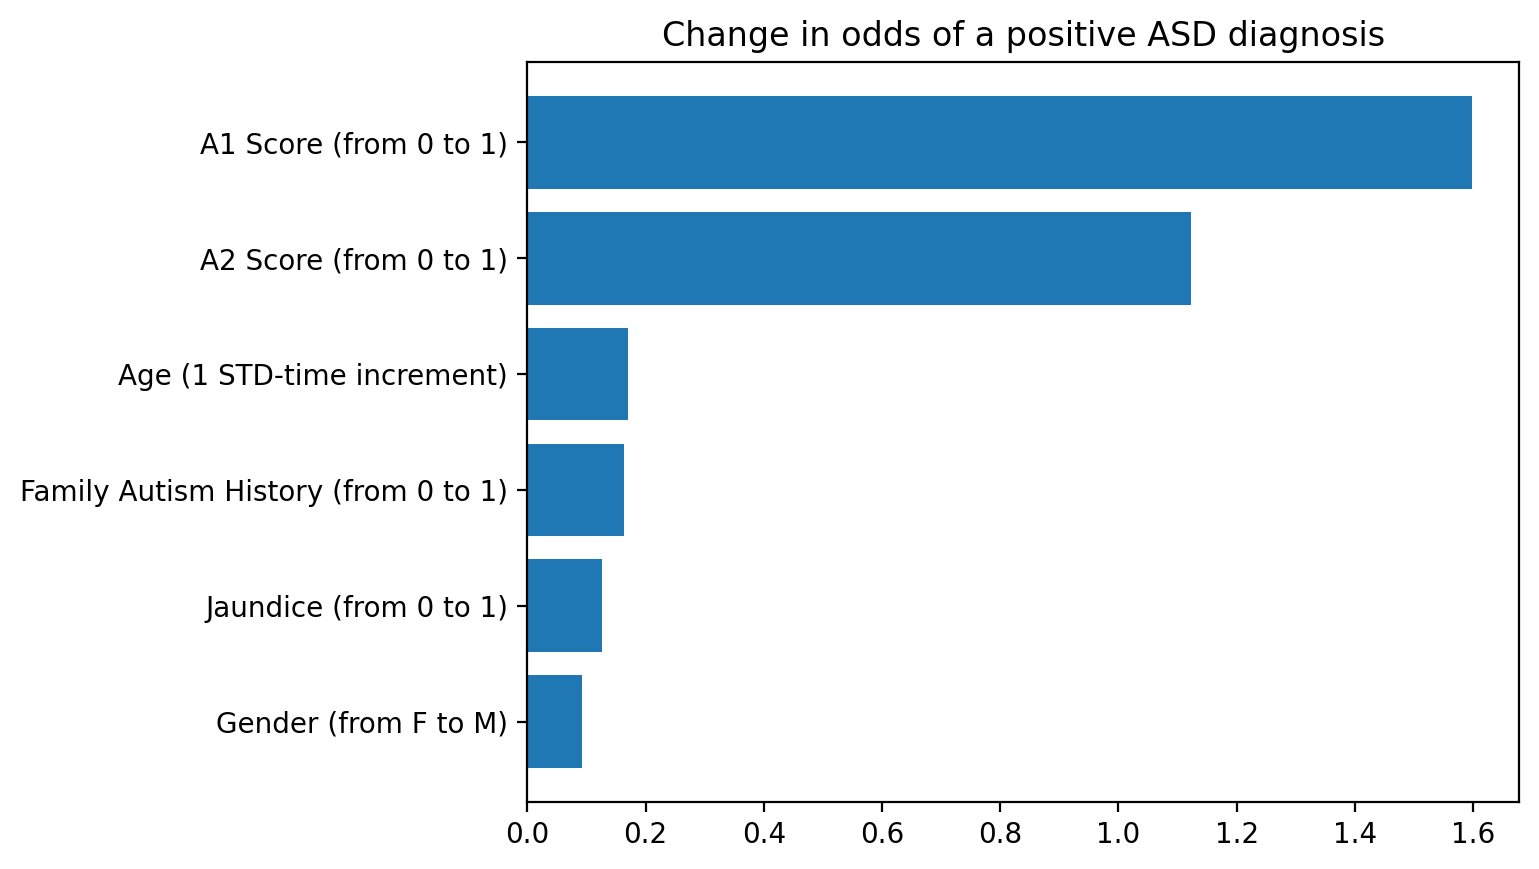

In [248]:
# Visualize feature importances with horizontal bar plot.

keys = odds_change_table_asc.keys()
values = odds_change_table_asc.values()
plt.barh(list(keys), list(values))
plt.title('Change in odds of a positive ASD diagnosis')
plt.show()

In [249]:
# Visualize feature importances with a table.

pd.DataFrame.from_dict(odds_change_table_desc, orient='index', columns=['Change in odds of positive ASD diagnosis'])


,Change in odds of positive ASD diagnosis
A1 Score (from 0 to 1),1.598671
A2 Score (from 0 to 1),1.123361
Age (1 STD-time increment),0.169996
Family Autism History (from 0 to 1),0.164160
Jaundice (from 0 to 1),0.126370
Gender (from F to M),0.093081


The trends we observe in the visualization of feature importances are largely sensible.


**What's sensible:**

- Being male (as opposed to female) increases the odds of a positive ASD diagnosis. We already know this from earlier.


- Having jaundice increases the odds of a positive ASD diagnosis. We already know this from earlier, too.


- Having a family history of autism increases the odds of a positive ASD diagnosis. This is consistent with [what we know](https://www.cdc.gov/genomics/disease/autism.htm#:~:text=Having%20a%20family%20health%20history,than%20one%20child%20with%20ASD).


**What's interesting:**

- Being older by one standard deviation (which would be about 8 years $-$ see cell below) increases the odds of a positive ASD diagnosis by about 17%. 


**What's unknown:**

- The variables **A1_Score** and **A2_Score** seem to have a disproportionately huge influence on a respondent's ASD diagnosis. This makes broad sense since we know these were answers to questions pertaining to a respondent's behavior. However, we lack detailed information on what said behaviors are, so we cannot comment further at this point.

In [252]:
X_train['age'].describe()

count    422.000000
mean      29.706161
std        8.269160
min       17.000000
25%       23.000000
50%       30.000000
75%       31.000000
max       60.000000
Name: age, dtype: float64

Indeed, we see that the respondents who had a positive ASD diagnosis tended to be slightly older (in the train set):

In [257]:
X_train.loc[y_train['ASD']==1]['age'].describe()

count    115.000000
mean      31.513043
std        9.098260
min       17.000000
25%       26.500000
50%       30.000000
75%       36.500000
max       60.000000
Name: age, dtype: float64

In [258]:
X_train.loc[y_train['ASD']==0]['age'].describe()

count    307.000000
mean      29.029316
std        7.845472
min       17.000000
25%       23.000000
50%       30.000000
75%       31.000000
max       58.000000
Name: age, dtype: float64

#### 6c. Using the model metrics and interpretability, let's jot down some thoughts we might have on why the model performed the way it did.

---

If we look at the metrics report (below) again, the model doesn't perform too badly *overall*. 

In [242]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       106
           1       0.57      0.37      0.45        35

    accuracy                           0.77       141
   macro avg       0.69      0.64      0.65       141
weighted avg       0.75      0.77      0.76       141



But if we restrict our attention to the positive class (i.e., **ASD** = 1), we notice that the model performs quite terribly. The reason is that the data set is actually imbalanced $-$ there are far more people diagnosed *without* ASD $-$ and we did not take that into account during feature processing and model training.

> My bad. The adage rings louder than ever: "Garbage in, garbage out".

In [224]:
data['ASD'].value_counts()

0    515
1    189
Name: ASD, dtype: int64

**Things that I could have done differently:**

- Inspect the distribution of the target variable during the EDA phase. (To be fair, that did cross my mind, but I was carried away by the other tasks and the time constraint.)


- Use techniques to deal with imbalanced data. Examples: (1) SMOTE - oversample minority class (**ASD** = 0) by generating synthetic samples in the minority class, (2) Use resampled data where majority class is undersampled during model training.

> To expand on the second method: One could use an ensemble of logistic regression models or decision tree models, where each model would be trained on a resampled data set composed of the minority class records and an equal number but different subset of the majority class records. 

## Step 7: Final Thoughts + Additional Info

---

It felt somewhat challenging to do EDA more thoroughly on this data set, due to the fact that it contained a mix of binary variables (pimarily; including the target variable itself), multi-categorical variables, and a quantitative variable. (So it would not make sense to use traditional correlation measures like Pearson correlation.) 


If I had more time, here's what I would do at the very beginning:

- To assess "correlation" between two binary variables (e.g., **ASD** and **jaundice**), use either a two-sampled Z-test for comparing two proportions, or [Jaccard similarity](https://www.statology.org/jaccard-similarity-python/).


- To assess "correlation" between multi-categorical variables (e.g., **ethnicity** and **country_of_res**), or between a multi-categorical variable and a binary variable, use a Chi-squared test for independence.


- To assess "correlation" between a quantitative variable and a binary variable (e.g., **age** and **ASD**), use a two-sample t-test for comparing two means.


- To assess "correlation" between a quantitative variable and a multi-categorical variable (e.g., **age** and **country_of_res**), use an ANOVA F-test for testing the equality of several means.

> **Note:** For the last two scenarios, we need to check that the quantitative variable (i.e., **age**) is normally distributed. We can do this using a QQ plot or something like the Shapiro-Wilk Test of Normality.

---

For the feature importance section, I contemplated using permutation feature importance (measures importance based on contribution to error/loss of the model) and SHAP feature importance (measures importance based on marginal contributions to the model's predictions). 


But using permutation feature importance would be unnecessary if we are using a logistic regression model, and SHAP feature importance can get computationally expensive.

---
**Final thought:** 

Besides accounting for the class imbalance in the data, I reckon experimenting with various imputation techniques would be our next-best bet to improve model performance. I just think that the presence of many NaNs (~90% collectively; converted to 'Unknowns') might have had a negative impact on model performance.